<a href="https://colab.research.google.com/github/bmercer486/tam470-tutorials/blob/main/point_jacobi_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point Jacobi Solver for 2D steady heat equation

## The example

This example presents code to numerically solve for the distribution of $T(x,y)$ in the plate with the BCs shown below. You can assume Dirichlet boundary conditions take precedence over the Neumann boundary conditions at the corners of the domain.

<p align='center'>
	<img src="https://github.com/bmercer486/tam470-tutorials/blob/main/plate2d.png?raw=1" alt="plate2d" width="300"/>
</p>

The PDE of interest is

<br>
\begin{equation}
\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y ^2} = 0
\end{equation}
<br>

The discretization assumes using $N+1$ points in each of the $x$ and $y$ directions, resulting in uniform grid spacing $h$. The discretized equation for interior nodes is:

<br>
\begin{equation}
-4T_{i,j} + T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} = 0, \quad i = 1, 2, ..., N-1, \quad j = 1, 2, ..., N-1
\end{equation}
<br>

On the right edge, where $i=N$, the insulated boundary condition implies

<br>
\begin{equation}
T_{N,j} = T_{N-1,j}, \quad j = 1, 2, ..., N-1
\end{equation}
<br>

## Point Jacobi implementation

To initialize the Point Jacobi scheme, pick an initial guess to kick off the iterations, $k=0$. All zeros is a common choice, with the exception of including known Dirichlet boundary values in the guess:

<br>
\begin{equation}
T^{k=0}(x, y) = \begin{cases}
			x(L-x)       & \text{if $y = 0$},\\
			0            & \text{otherwise}
		\end{cases}
\end{equation}
<br>

If each equation in the system of equations is written in the format

<br>
$$
A_{ii}x_i +\sum_{j\ne i} A_{ij}x_j = b_i
$$
<br>

Then the Point Jacobi update rule is

<br>
$$
x_i^{(k+1)} = \frac{1}{A_{ii}}\left(b_i-\sum_{j\ne i} A_{ij}x_j^{(k)}\right)
$$
<br>

There are two viable approaches to handling boundary conditions; each is described and implemented below

### Handling Boundary conditions: Option 1
For interior with index $i = N-1$, the term $T_{N,j}$ appears. We can use the boundary condition $T_{N,j} = T_{N-1,j}$ to remove $T_{N,j}$ from the equations.

In this case the full system of equations becomes:

<b>For interior nodes next to the Neumann boundary:</b> $i = N-1, \quad j = 1, 2, ..., N-1$

<br>
$$
-3T_{i,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} = 0
$$
<br>

<b>For all other interior nodes:</b> $i = 1,2,...,N-2, \quad j = 1, 2, ..., N-1$

<br>
$$
-4T_{i,j} + T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} = 0
$$
<br>

Point Jacobi would be used to solve for all interior node values. <b>After achieving converged values at interior nodes</b>, the Neumann boundary condition would be applied to nodes on the right boundary:

<br>
\begin{equation}
T_{N,j} = T_{N-1,j}, \quad j = 1, 2, ..., N-1
\end{equation}
<br>

The code below implements this scheme.

Converged in 1716 iterations
|T(final)-T(previous)|= 0.000000998981


Text(0, 0.5, 'd')

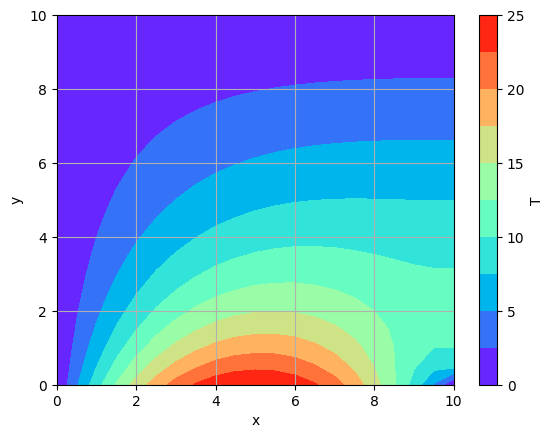

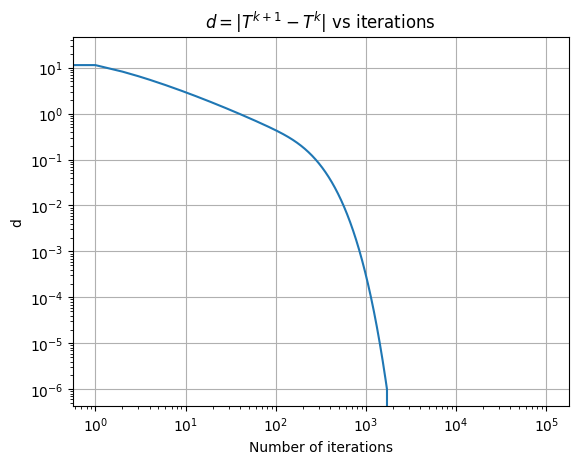

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def PJitersolve(L, N, tol, maxiter, print_iters=False):

    # Discretization
    x = np.linspace(0, L, N+1)
    y = np.linspace(0, L, N+1)

    # Initialize
    T = np.zeros((N+1, N+1))
    T[:,0] = x*(L - x) # Incorporate known Dirichlet BCs into the initial guess

    # Track convergence
    dvals = np.zeros(maxiter)

    # Point Jacobi
    converged = False
    iter = 0
    if(print_iters):
        print('Iteration k:   |T(k+1) - T(k)|')
    while(not converged):

        # The 'old' guess (iteration k) is saved as the result from the previous guess
        Told = np.copy(T)

        # Iteration counter
        iter += 1

        # Loop over all interior nodes
        for i in range(1, N):
            for j in range(1, N):

                # Interior nodes affected by the Neumann condition: i=N-1
                if(i==N-1):
                    T[i,j] = (1/3)*(Told[i-1,j] + Told[i,j+1] + Told[i,j-1])

                # All other interior nodes
                else:
                    T[i,j] = (1/4)*(Told[i+1,j] + Told[i-1,j] + Told[i,j+1] + Told[i,j-1])

        # Check if converged (apply norm to interior nodes only)
        d = np.linalg.norm(T[1:-1, 1:-1] - Told[1:-1, 1:-1])
        dvals[iter-1] = d

        # Print convergence behavior (helpful for debugging)
        if(print_iters and iter % 10 == 0):
            print(f'{iter:.0f} {d:25.8f}')

        # Accept or reject current solution
        if(d < tol):
            converged = True
            print(f'Converged in {iter} iterations')
            print(f'|T(final)-T(previous)|= {d:.12f}')

            # Impose the Neumann condition on the right edge where i=N
            for j in range(1, N):
                T[N, j] = T[N-1, j]

        elif(iter==maxiter):
            print('no convergence')
            break

    return x, y, T, iter, dvals

# Domain and discretization
L = 10
N = 20

# Convergence criteria
tol = 1e-6
maxiter = 100000

# Point Jacobi
x, y, T, iter, dvals = PJitersolve(L, N, tol, maxiter, print_iters=False)

# Plot solution
X, Y = np.meshgrid(x, y)
plt.figure()
contour_regions = np.linspace(0, np.max(T), 11)
plt.contourf(X, Y, T.T, levels=contour_regions, cmap='rainbow')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('T', rotation=90)
plt.grid()

# Plot convergence
plt.figure()
plt.loglog(dvals)
plt.title(r'$d = |T^{k+1} - T^k|$ vs iterations')
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('d')

### Handling Boundary conditions: Option 2

In this treatment, the non-Dirichlet boundary nodes are included in the system of equations and solved for during iterations. This is simpler, because we don't need to modify any equations for interior nodes, but is less efficient.

The full system of equations becomes (skipping Dirichlet equations):

<b> For nodes on right boundary:</b> $i=N, \quad j = 1, 2, ..., N-1$

<br>
$$
T_{i,j} = T_{i-1,j}
$$
<br>

<b>For all interior nodes</b> $i=1,2,...N-1, \quad j = 1,2, ..., N-1$

<br>
$$
-4T_{i,j} + T_{i+1,j} + T_{i-1,j} + T_{i,j+1} + T_{i,j-1} = 0
$$
<br>

The code below implements the scheme. It loops on **all** nodes, including boundary nodes, which is where it differs from the previous option.

It will still converge to the right answer, but will take more iterations than the previous example.

Converged in 1805 iterations
|T(final)-T(previous)|= 0.000000995253


Text(0, 0.5, 'd')

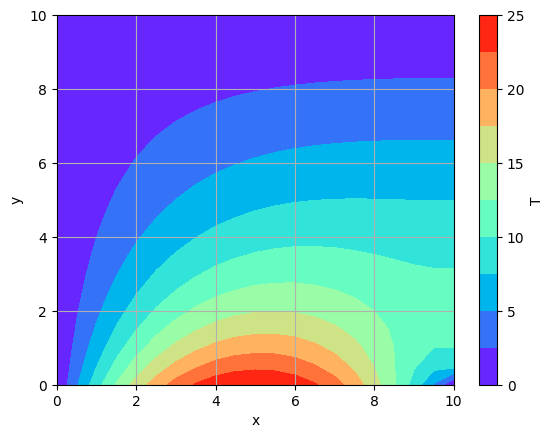

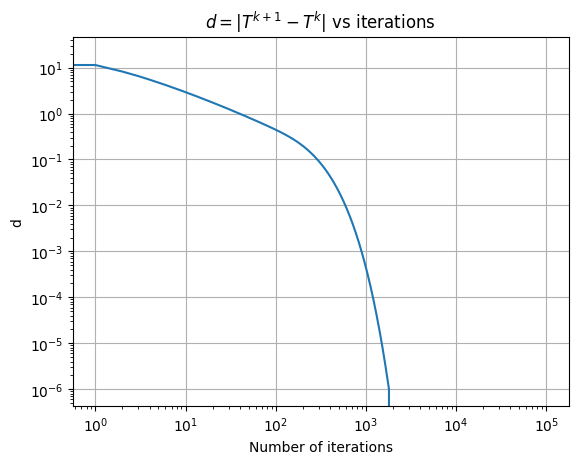

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def PJitersolve_alternate(L, N, tol, maxiter, print_iters=False):

    # Discretization
    x = np.linspace(0, L, N+1)
    y = np.linspace(0, L, N+1)

    # Initialize
    T = np.zeros((N+1, N+1))
    T[:,0] = x*(L - x) # Incorporate known Dirichlet BCs into the initial guess

    # Track convergence
    dvals = np.zeros(maxiter)

    # Point Jacobi
    converged = False
    iter = 0
    if(print_iters):
        print('Iteration k:   |T(k+1) - T(k)|')
    while(not converged):

        # The 'old' guess (iteration k) is saved as the result from the previous guess
        Told = np.copy(T)

        # Iteration counter
        iter += 1

        # Loop over all nodes
        for i in range(N+1):
            for j in range(N+1):

                # Do nothing for Dirichlet boundary nodes
                if(i==0 or j==0 or j==N):
                    continue

                # Nodes with a Neumann boundary condition
                if(i==N):
                    T[i,j] = Told[i-1,j]

                # All interior nodes
                else:
                    T[i,j] = (1/4)*(Told[i+1,j] + Told[i-1,j] + Told[i,j+1] + Told[i,j-1])

        # Check if converged
        d = np.linalg.norm(T - Told)
        dvals[iter-1] = d

        # Print convergence behavior (helpful for debugging)
        if(print_iters and iter % 100 == 0):
            print(f'{iter:.0f} {d:25.8f}')

        # Accept or reject current solution
        if(d < tol):
            converged = True
            print(f'Converged in {iter} iterations')
            print(f'|T(final)-T(previous)|= {d:.12f}')
        elif(iter==maxiter):
            print('no convergence')
            break

    return x, y, T, iter, dvals

# Domain and discretization
L = 10
N = 20

# Convergence criteria
tol = 1e-6
maxiter = 100000

# Point Jacobi
x, y, T, iter, dvals = PJitersolve_alternate(L, N, tol, maxiter, print_iters=False)

# Plot solution
X, Y = np.meshgrid(x, y)
plt.figure()
contour_regions = np.linspace(0, np.max(T), 11)
plt.contourf(X, Y, T.T, levels=contour_regions, cmap='rainbow')
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('T', rotation=90)
plt.grid()

# Plot convergence
plt.figure()
plt.loglog(dvals)
plt.title(r'$d = |T^{k+1} - T^k|$ vs iterations')
plt.grid()
plt.xlabel('Number of iterations')
plt.ylabel('d')